In [7]:
!git clone https://github.com/Mark-Vergouwen/CPD.git
%cd CPD
!ls
!pip install ruptures

In [5]:
# Import packages
import os
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import numpy as np 

# Import functions from GitHub
import sys
sys.path.append("scripts")
import preprocessing_df
import detect_changepoints
import detect_sessions
import plot_changepoints
import plot_changepoints_sessions

# Import data from GitHub
batch_files = [f"FluviusPublicEV_batch_{i}.csv" for i in range(1, 11)]

# Read and combine all batch files
df_list = [pd.read_csv(os.path.join("data", file), delimiter=",") for file in batch_files]
df = pd.concat(df_list, ignore_index=True)

# # Select 1 EAN (choose EV-owning EAN)
df_ean = df[(df["EAN_ID"] == 1001)]
df_ean = df_ean.copy()
df_ean.rename(columns={
    "Volume_Afname_kWh": "afname_kwh",
    "Datum_Startuur": "datetime"
}, inplace=True)
print(df_ean)


,recordid,_record_id,record_timestamp,_record_timestamp,record_size,_record_size,resource_id,_resource_id


## 1. Preprocessing

             datetime  total_kwh  max_kw  range_kw
0 2022-01-01 00:00:00      2.137   2.276     0.240
1 2022-01-01 01:00:00      2.057   2.088     0.080
2 2022-01-01 02:00:00      2.020   2.128     0.176
3 2022-01-01 03:00:00      1.978   2.004     0.064
4 2022-01-01 04:00:00      1.990   2.036     0.104


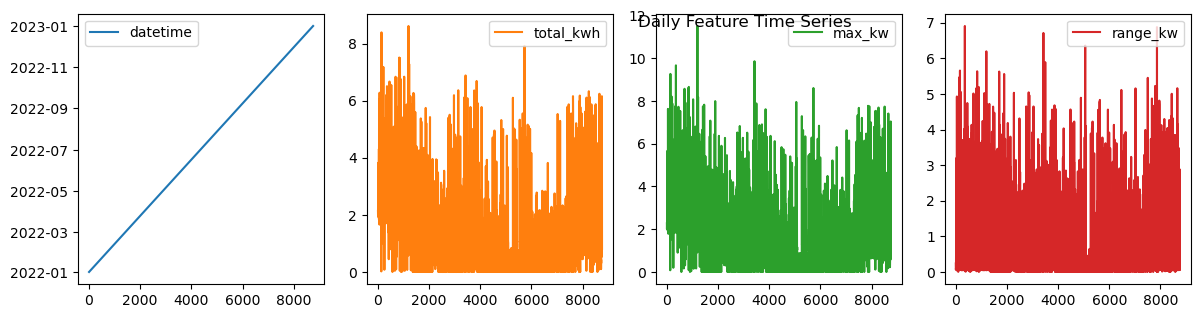

In [19]:
features_df = preprocessing_df.preprocessing(df_ean)
print(features_df.head())
%matplotlib inline
features_df.plot(subplots=True, layout=(8, 5), figsize=(15, 25), title='Daily Feature Time Series')
plt.tight_layout()
plt.show()

## 2. Detecting and plotting individual changepoints

Aggregated Breakpoints:
2022-01-01 10:00:00 -> ['range_kw', 'max_kw']
2022-01-01 20:00:00 -> ['range_kw', 'max_kw']
2022-01-02 11:00:00 -> ['range_kw', 'max_kw']
2022-01-02 21:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-03 12:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-03 17:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-04 18:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-04 23:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-05 09:00:00 -> ['range_kw', 'max_kw']
2022-01-05 14:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-05 19:00:00 -> ['range_kw', 'max_kw']
2022-01-06 00:00:00 -> ['total_kwh', 'max_kw']
2022-01-06 10:00:00 -> ['total_kwh', 'max_kw']
2022-01-06 15:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-06 20:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-07 16:00:00 -> ['total_kwh', 'range_kw', 'max_kw']
2022-01-07 21:00:00 -> ['total_kwh', 'range_kw', 'max_kw']


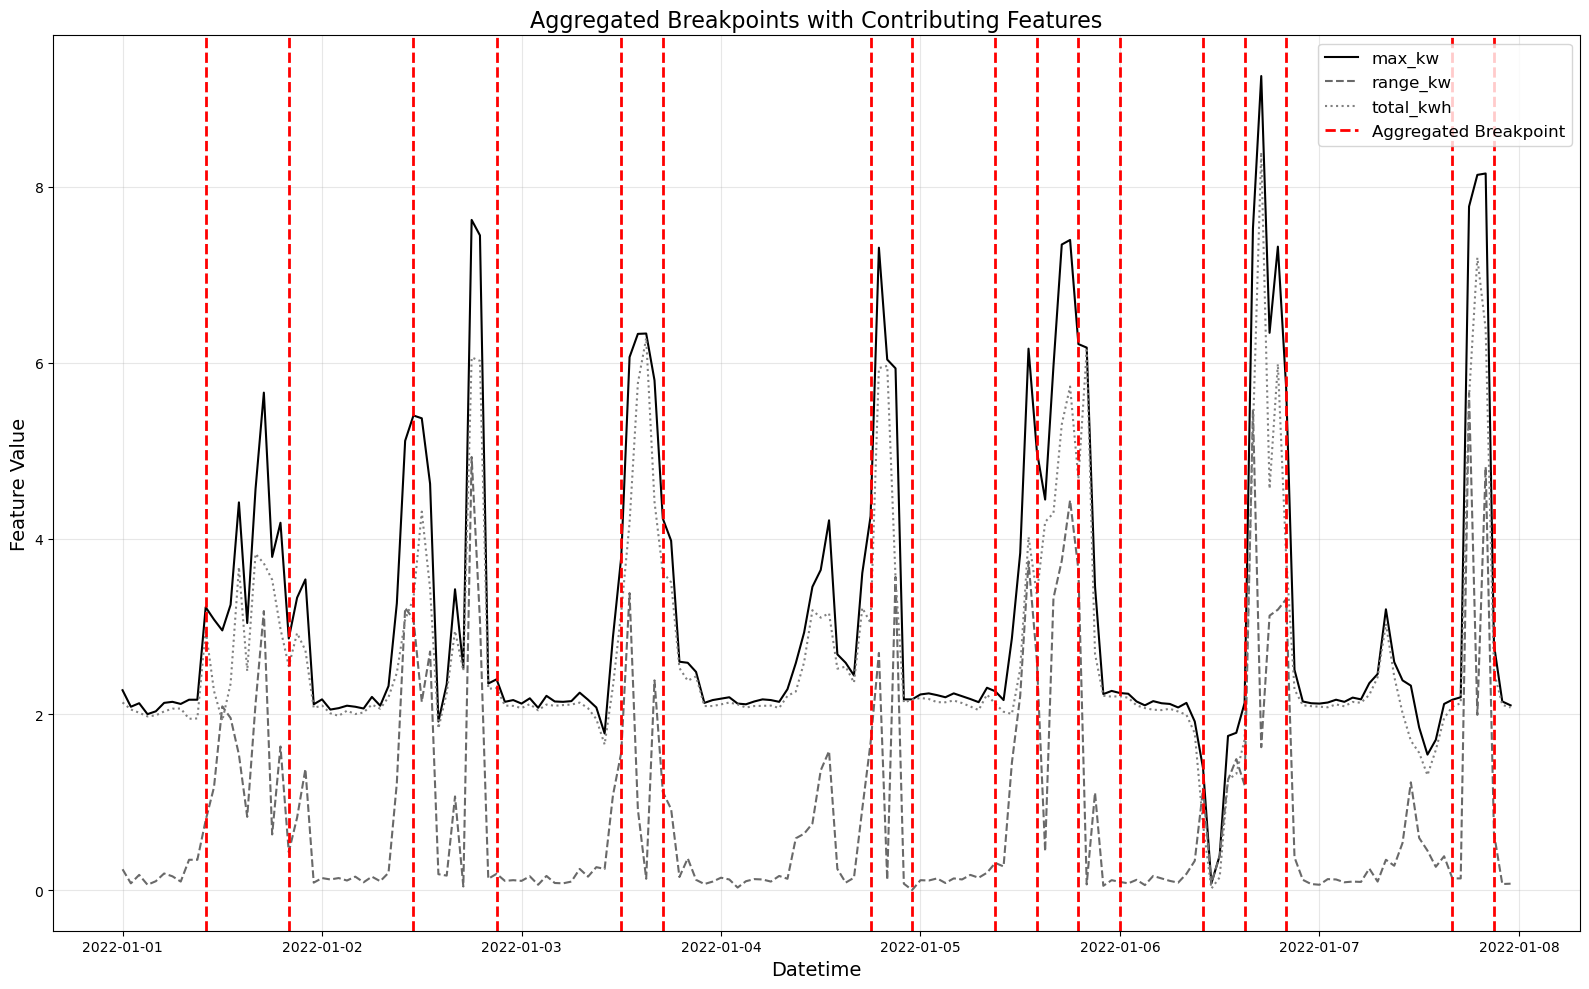

In [39]:
# 0. Select 1 week of data
start_date = "2022-01-01"
end_date = "2022-01-08" 
features_df = features_df[(features_df["datetime"] >= start_date) & (features_df["datetime"] < end_date)]

# 1. Changepoint detection function
aggregated_breakpoints, contrib_features_dict = detect_changepoints.detect_changepoints(features_df, method = 'pelt', model = 'l2', penalty=3, min_size_hours=2, merge_tolerance_hours=4, n_contributing_features = 2)
print("Aggregated Breakpoints:")
for bkp in aggregated_breakpoints:
    print(f"{bkp} -> {contrib_features_dict[bkp]}")

# 2. Changepoint visualization function
plot_changepoints.plot_changepoints(aggregated_breakpoints, contrib_features_dict, features_df)


## 3. Detecting and plotting charging sessions

Charging session from 2022-01-02 11:00:00 to 2022-01-02 21:00:00
Charging session from 2022-01-03 12:00:00 to 2022-01-03 17:00:00
Charging session from 2022-01-04 18:00:00 to 2022-01-04 23:00:00
Charging session from 2022-01-05 14:00:00 to 2022-01-05 19:00:00
Charging session from 2022-01-06 15:00:00 to 2022-01-06 20:00:00
Charging session from 2022-01-07 16:00:00 to 2022-01-07 21:00:00


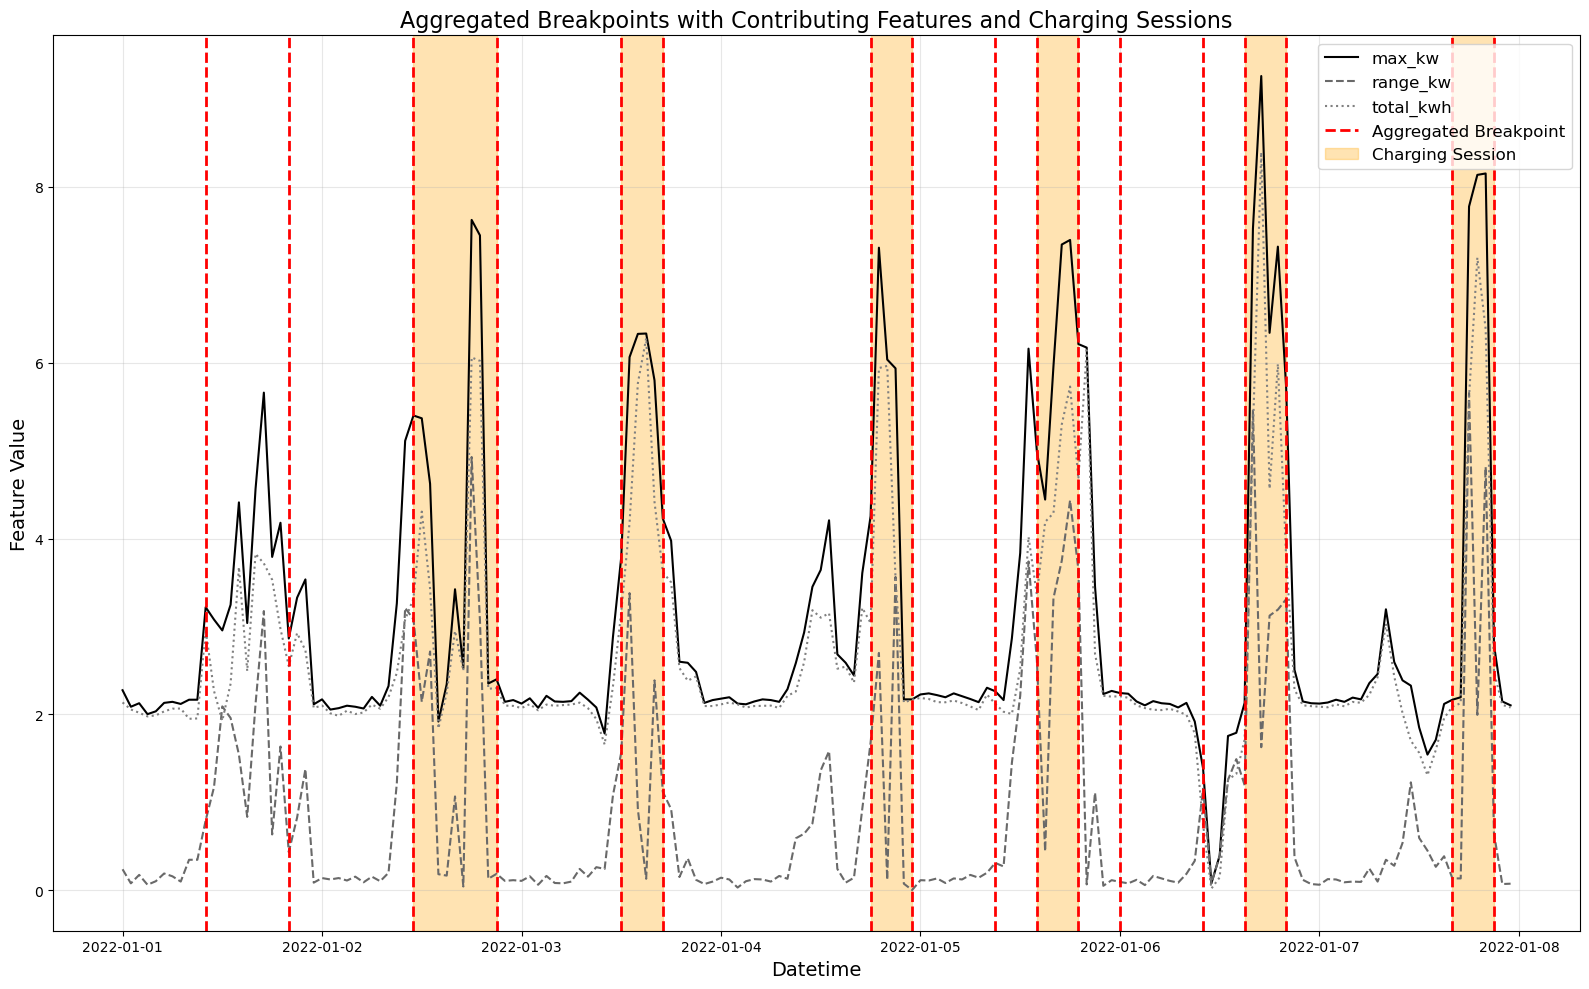

In [31]:
# Identify charging sessions
sessions = detect_sessions.detect_sessions(df=features_df, 
                                                aggregated_breakpoints=aggregated_breakpoints,
                                                contrib_features_dict=contrib_features_dict)

# Output the results
for session in sessions:
    print(f"Charging session from {session[0]} to {session[1]}")


plot_changepoints_sessions.plot_changepoints_sessions(aggregated_breakpoints, contrib_features_dict, features_df, sessions)
